
Ungraded Lab: Cats vs. Dogs Class Activation Maps

You will again practice with CAMs in this lab and this time there will only be two classes: Cats and Dogs. You will be revisiting this exercise in this week's programming assignment so it's best if you become familiar with the steps discussed here, particularly in preprocessing the image and building the model.

https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/3-Advance_computer_vision/week-4/C3_W4_Lab_2_CatsDogs_CAM.ipynb


In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:


train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)



In [5]:


def augment_images(image, label):
  
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)



In [6]:
# define the model
kernel = (3,3)
act = 'relu'
pad = 'same'
pool = (2,2)

input_layer = Input(shape=(300, 300, 3))

x = Conv2D(16, kernel_size= kernel, activation=act, padding=pad)(input_layer)
x = MaxPooling2D(pool_size=pool)(x)

x = Conv2D(32, kernel_size= kernel, activation=act, padding=pad)(x)
x = MaxPooling2D(pool_size=pool)(x)

x = Conv2D(64, kernel_size= kernel, activation=act, padding=pad)(x)
x = MaxPooling2D(pool_size=pool)(x)

x = Conv2D(128, kernel_size= kernel, activation=act, padding=pad)(x)
x = GlobalAveragePooling2D()(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0     

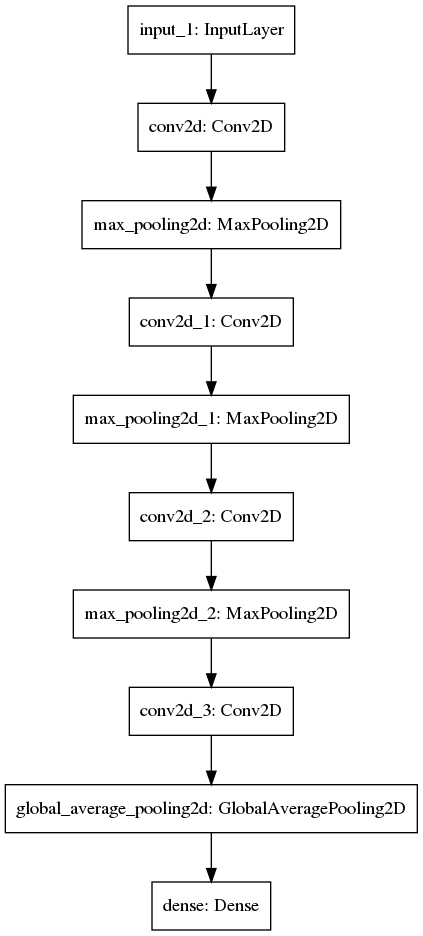

In [7]:
plot_model(model)

In [14]:
# takes around 30 minutes to train on a gpu!
import datetime
now = datetime.datetime.now()

es = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=3, verbose=0)

model.compile(loss='binary_crossentropy',metrics=['accuracy'],
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

history = model.fit(train_batches, epochs=25,  callbacks=[es])

now = datetime.datetime.now() - now
hour = '{:02d}'.format(now.hour)
minute = '{:02d}'.format(now.minute)

print(f"training took {hour}:{minute}")

Epoch 1/25
582/582 [==============================] - 37s 54ms/step - loss: 0.6602 - accuracy: 0.5916
Epoch 2/25
582/582 [==============================] - 31s 52ms/step - loss: 0.6321 - accuracy: 0.6337
Epoch 3/25
582/582 [==============================] - 32s 55ms/step - loss: 0.6106 - accuracy: 0.6634
Epoch 4/25
582/582 [==============================] - 31s 53ms/step - loss: 0.5893 - accuracy: 0.6896
Epoch 5/25
582/582 [==============================] - 30s 51ms/step - loss: 0.5746 - accuracy: 0.7054
Epoch 6/25
582/582 [==============================] - 33s 55ms/step - loss: 0.5605 - accuracy: 0.7150
Epoch 7/25
582/582 [==============================] - 32s 54ms/step - loss: 0.5513 - accuracy: 0.7211
Epoch 8/25
582/582 [==============================] - 31s 52ms/step - loss: 0.5376 - accuracy: 0.7364
Epoch 9/25
582/582 [==============================] - 31s 53ms/step - loss: 0.5302 - accuracy: 0.7413
Epoch 10/25
582/582 [==============================] - 31s 52ms/step - loss: 0.523

AttributeError: 'datetime.timedelta' object has no attribute 'hour'

dict_keys(['loss', 'accuracy'])


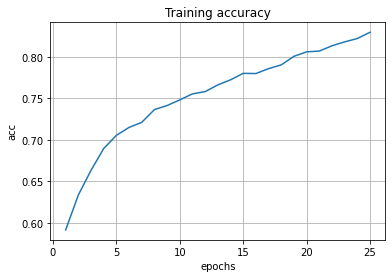

In [15]:
print(history.history.keys())
x_axis = np.arange(1, len(history.history['accuracy'])+1 )
y_axis = history.history['accuracy']
plt.plot(x_axis, y_axis)
plt.title('Training accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid()

In [16]:
# The cap model
# now create the CAM (class activation map) model
# we do this so we can get the output of the last conv
# as well as the classifier output
gap_weights = model.layers[-1].get_weights()[0]
print(gap_weights.shape)

last_conv_layer = model.layers[-3].output
dense_classifier_layer = model.layers[-1].output

cam_model = Model(inputs = model.input, outputs = (last_conv_layer, dense_classifier_layer))
cam_model.summary()



(128, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)   

In [17]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

    # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=5)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

   # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


--2022-01-23 14:51:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.1.16, 172.217.165.16, 142.251.32.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.1.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.09s   

2022-01-23 14:51:14 (4.46 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2022-01-23 14:51:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.41.80, 142.251.33.176, 142.251.32.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.41.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Saving to: ‘cat2.jpg’

cat2.jp

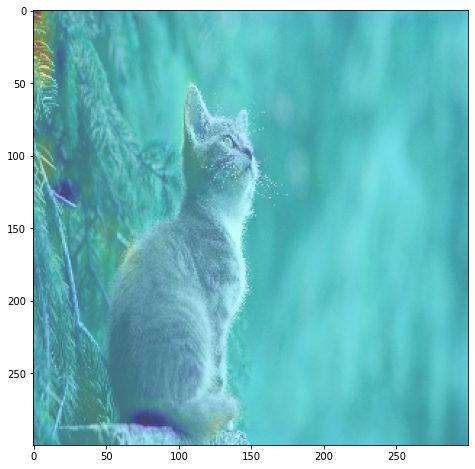

sigmoid output: [[0.6753479]]
prediction: dog


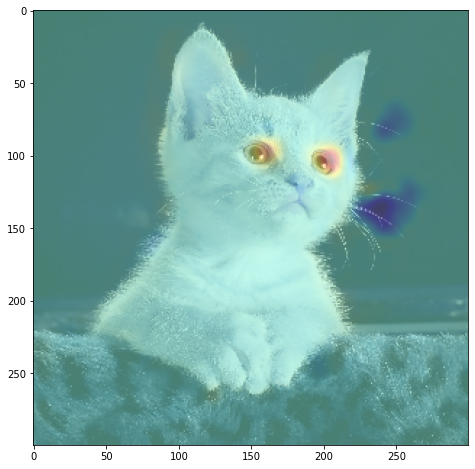

sigmoid output: [[0.7152638]]
prediction: dog


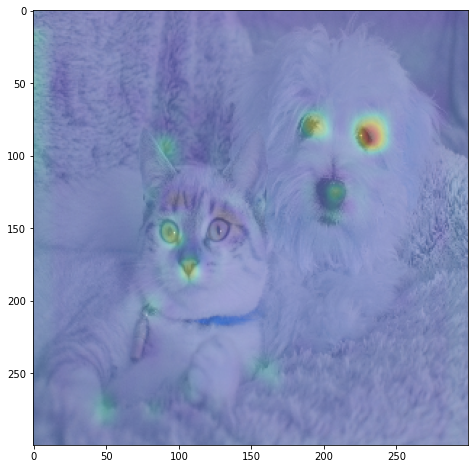

sigmoid output: [[0.42328325]]
prediction: cat


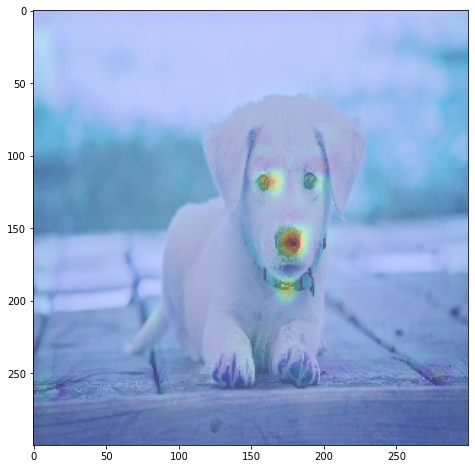

sigmoid output: [[0.5917392]]
prediction: dog


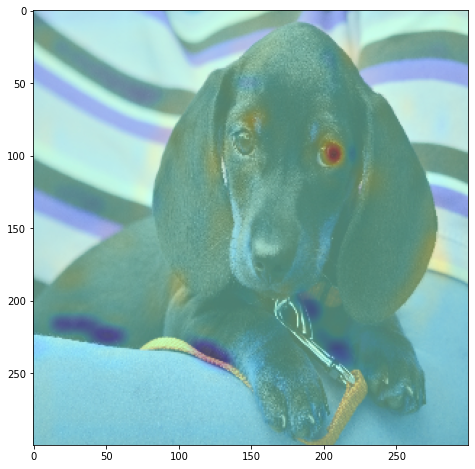

In [18]:
!wget -O cat1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
!wget -O cat2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
!wget -O catanddog.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/catanddog.jpg
!wget -O dog1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg
!wget -O dog2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg

# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')


ground truth: cat
sigmoid output: [[0.54741204]]
prediction: dog


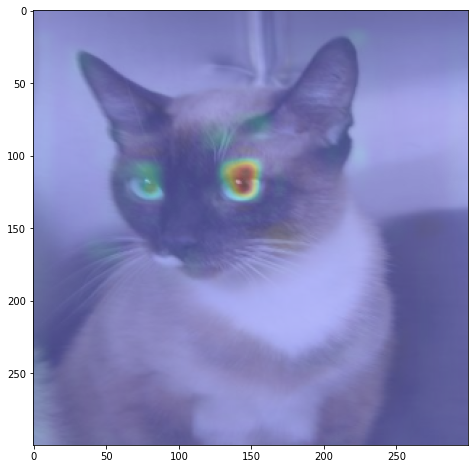

ground truth: dog
sigmoid output: [[0.40435943]]
prediction: cat


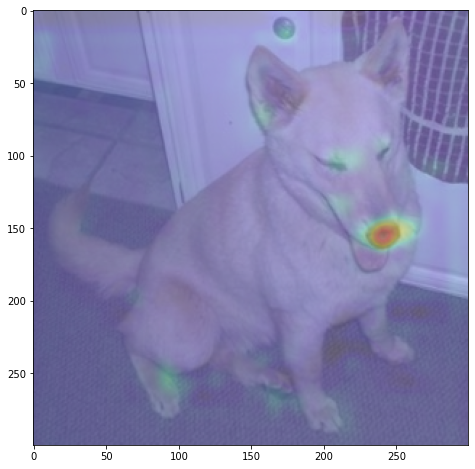

ground truth: dog
sigmoid output: [[0.63354945]]
prediction: dog


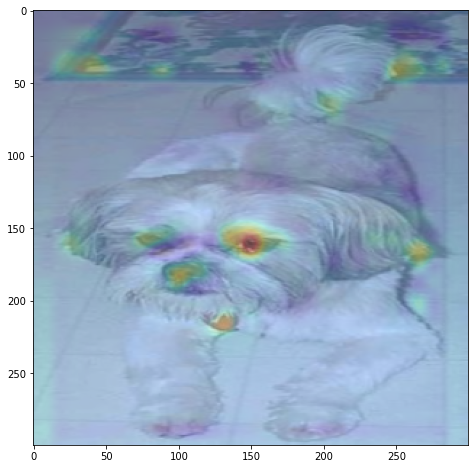

ground truth: cat
sigmoid output: [[0.07997206]]
prediction: cat


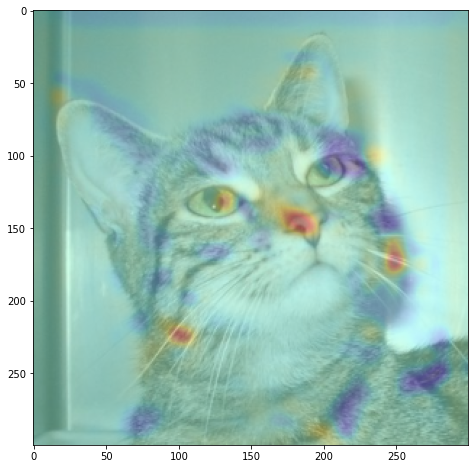

ground truth: cat
sigmoid output: [[0.37353832]]
prediction: cat


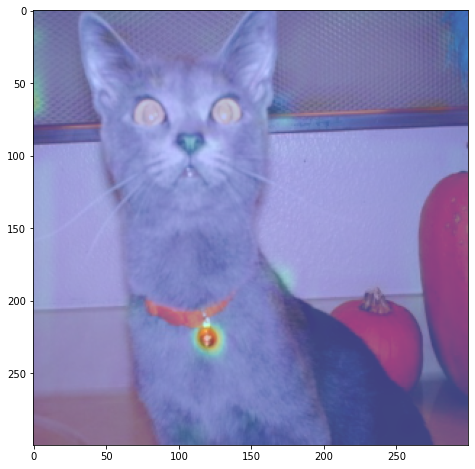

In [19]:
# also try with test images


# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)

If your training reached 80% accuracy, you may notice from the images above that the presence of eyes and nose play a big part in determining a dog, while whiskers and a colar mostly point to a cat. Some can be misclassified based on the presence or absence of these features. This tells us that the model is not yet performing optimally and we need to tweak our process (e.g. add more data, train longer, use a different model, etc).